# Read in data, remove unnecessary columns
We are keeping Latitude, Longitude, Speed, Heading, MMSI, and the Timestamp

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv("C:\\Users\\DSU\\Desktop\\AllCurrentClasses\\AISweden\\FinalDeliverable\\BalticDataTrain\\training_set.csv")

data = data[["timestamp", "mmsi", "lat", "lon", "speed", "heading"]]
data.head()

C:\Users\DSU\AppData\Local\Temp\ipykernel_25208\3187478731.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:\\Users\\DSU\\Desktop\\AllCurrentClasses\\AISweden\\FinalDeliverable\\BalticDataTrain\\training_set.csv")


,timestamp,mmsi,lat,lon,speed,heading
0,2017-11-02 11:19:07,205366000,54.347242,9.991140,4.01,56.0
1,2017-11-02 11:30:58,205366000,54.360348,10.025337,4.17,81.0
2,2017-11-02 11:37:58,205366000,54.359573,10.049203,4.48,92.0
3,2017-11-02 11:44:07,205366000,54.365497,10.071320,3.81,46.0
4,2017-11-02 11:56:08,205366000,54.370437,10.109498,2.73,103.0


# Remove null values, if any exist

In [4]:
data.dropna(inplace=True)

# Remove all speeds over 50 knots

In [5]:
data = data[data["speed"] <= 50]

# Convert timestamp to seconds

In [6]:
# figure out time passed
from datetime import datetime

data["timePassed"] = 0

for i in range(len(data["timestamp"])):
    dateObj = datetime.strptime(data.iloc[i, data.columns.get_loc("timestamp")], '%Y-%m-%d %H:%M:%S')
    data.iloc[i, data.columns.get_loc("timePassed")] = dateObj.timestamp()

# Sort first by MMSI and second by timestamp
# Then calculate timestep inbetween each message
# Whenever mmsi changes or the timestep goes over the limit (1 hr in our case) increment a path counter

In [7]:
# Sort
data.sort_values(by=["mmsi", "timePassed"], inplace=True)

# Initialize data and variables for timestep
data["timeStep"] = 0
lastTime = -1
mmsiOn = -1
# Initialize data and variables for pathCounter
data["path"] = 0
pathCounter = -1
maxTime = 3600


for i in range(len(data["timestamp"])):
    row = data.iloc[i]
    mmsi = row["mmsi"]
    timePassed = row["timePassed"]
    
    if(mmsi != mmsiOn): # If the mmsi has changed
        pathCounter += 1
        mmsiOn = mmsi
        lastTime = timePassed
    if((timePassed - lastTime) > maxTime): # If the time goes over the limit
        pathCounter += 1
        lastTime = timePassed

    # update with new time
    data.iloc[i, data.columns.get_loc("timeStep")] = timePassed - lastTime
    # update with the pathCounter
    data.iloc[i, data.columns.get_loc("path")] = pathCounter
    # reset lastTime
    lastTime = timePassed

# Calculate path length and store them to a table

In [8]:
# Table to use
pathCounts = pd.DataFrame(columns=["path", "pathLength"])

# Variables
pathOn = 0
pathLength = 0

for i in range(len(data["path"])):
    row = data.iloc[i]

    if(pathOn != row["path"]): # New path reached
        # Save path to table
        pathCounts.loc[len(pathCounts)] = [pathOn, pathLength]
        # Reset variables
        pathOn = row["path"]
        pathLength = 0
    pathLength += 1

# Create a threshold for path length
Our model uses path lengths of 24 to 144. Since the paths are on average about 10 minutes apart, this means that the paths generally have a timeframe of 240 to 1440 minutes, or 6 to 36 hours of points. Since we are examining longer paths, this works well for us.

In [9]:
pathMin = 24
pathMax = 144
pathElim = []

for i in range(len(pathCounts["path"])):
    row = pathCounts.iloc[i]
    if(row["pathLength"] < pathMin or row["pathLength"] > pathMax):
        # Setup path for elimination, it is too big or too small
        pathElim.append(row["path"])


In [12]:
print("Original Count of Paths: ", len(pathCounts["path"]))
print("Paths of Invalid Size: ", len(pathElim))
print("Paths Left: ", len(pathCounts["path"]) - len(pathElim))

Original Count of Paths:  201782
Paths of Invalid Size:  187297
Paths Left:  14485


# Remove paths that are too small
This is done now so that the rest of the preprocessing steps do not take too long.

In [14]:
data["Elim"] = 0
print("Points to iterate through: ", len(data["mmsi"]))

indexT = 0
for i in range(len(data["mmsi"])):
    # cycle through all points
    row = data.iloc[i]

    if(row["path"] > pathElim[indexT]):
        indexT += 1
    if(row["path"] == pathElim[indexT]):
        data.iloc[i, data.columns.get_loc("Elim")] = 1
    if(i % 100000 == 0):
        print("Points completed: ", i)

Points to iterate through:  13828475
Points completed:  0
Points completed:  100000
Points completed:  200000
Points completed:  300000
Points completed:  400000
Points completed:  500000
Points completed:  600000
Points completed:  700000
Points completed:  800000
Points completed:  900000
Points completed:  1000000
Points completed:  1100000
Points completed:  1200000
Points completed:  1300000
Points completed:  1400000
Points completed:  1500000
Points completed:  1600000
Points completed:  1700000
Points completed:  1800000
Points completed:  1900000
Points completed:  2000000
Points completed:  2100000
Points completed:  2200000
Points completed:  2300000
Points completed:  2400000
Points completed:  2500000
Points completed:  2600000
Points completed:  2700000
Points completed:  2800000
Points completed:  2900000
Points completed:  3000000
Points completed:  3100000
Points completed:  3200000
Points completed:  3300000
Points completed:  3400000
Points completed:  3500000
Points

IndexError: list index out of range

In [15]:
# Keep only data not set to be eliminated
data = data[data["Elim"] == 0]

# Eliminate Invalid Points
A point is invalid if it travels over a speed of 40 knots using the distance traveled between timesteps (NOT using the speed column)

In [31]:
import math
# Function to calculate distance/speed of ship between timestamps
def DistSpeed(latOld, lonOld, latNew, lonNew, timePassed):
    # first calculate distance
    d = (math.sin(math.radians(latOld)) * math.sin(math.radians(latNew))) + (math.cos(math.radians(latOld)) * math.cos(math.radians(latNew))) * (math.cos(math.radians(lonNew) - math.radians(lonOld)))
    if(d > 1):
        d = 1
    dist = math.acos(d) * 6371
    # convert from km to nautical miles
    nauticalMiles = dist * 0.5399568035
    # divide distance by timePassed to get knots, formula: distance * 3600 / timePassed (since timePassed is in seconds)
    speed = nauticalMiles * 3600 / timePassed
    return speed

latOld = 0
lonOld = 0
pathOn = -1
timeOld = 0

for i in range(len(data["path"])):
    row = data.iloc[i]
    # unnomralize values
    if(row["path"] == pathOn):
        # Calculate speed
        speed = DistSpeed(latOld, lonOld, row["lat"], row["lon"], row["timeStep"])
        if(speed > 40):
            # speed > 40 knots, probably not a valid point
            data.iloc[i, data.columns.get_loc("Elim")] = 1
    else:
        # skip check step, update pathOn
        pathOn = row["path"]

    # at end, set up latOld and lonOld
    latOld = row["lat"]
    lonOld = row["lon"]
    

In [32]:
pathsE = data[data["Elim"] == 1]["path"]
print(pathsE)
for i in pathsE:
    data = data[data["path"] != i]

Series([], Name: path, dtype: int64)


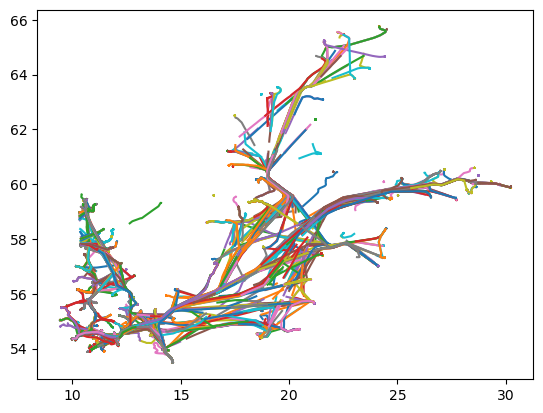

In [43]:
import matplotlib.pyplot as plt
arrMmsi = pd.unique(data["path"])
for i in range(2000):
    mmsi = arrMmsi[i]
    tmp = data[data["path"] == mmsi]
    x = tmp["lon"]
    y = tmp["lat"]
    plt.plot(x, y, "-")

#data[]
#x = data["lon"]
#y = data["lat"]
#plt.plot(x, y, "-")
plt.show()


In [17]:
# Keep only data not set to be eliminated
data = data[data["Elim"] == 0]

# Normalize Data
Lat = (lat - lat_min) / (lat_max-lat_min)
Lon = (lon - lon_min) / (lon_max-lon_min)
Speed = speed / 50
Heading = heading / 360

In [18]:
lat_min = 53.4
lat_max = 66.2
lon_min = 9.4
lon_max = 30.5
maxSpeed = 50
maxHeading = 360
data["alat"] = 0.0
data["alon"] = 0.0
data["aspeed"] = 0.0
data["aheading"] = 0.0

for i in range(len(data["mmsi"])):
    row = data.iloc[i]

    data.iloc[i, data.columns.get_loc("alat")] = (row["lat"] - lat_min) / (lat_max - lat_min)
    data.iloc[i, data.columns.get_loc("alon")] = (row["lon"] - lon_min) / (lon_max - lon_min)
    data.iloc[i, data.columns.get_loc("aspeed")] = row["speed"] / maxSpeed
    data.iloc[i, data.columns.get_loc("aheading")] = row["heading"] / maxHeading
    

# Split Train, Test, and Validate (We use 80-10-10 splits)

In [22]:
trainCount = len(data["mmsi"]) * 0.8
testValCount = len(data["mmsi"]) * 0.1
print("80%: ", trainCount)
print("10%: ", trainCount + testValCount)
trainPath = data.iloc[int(trainCount), data.columns.get_loc("path")]
valPath = data.iloc[int(trainCount + testValCount), data.columns.get_loc("path")]
testValData = data[data["path"] > trainPath]

dataTrain = data[data["path"] <= trainPath]
dataVal = testValData[testValData["path"] <= valPath]
dataTest = testValData[testValData["path"] > valPath]

80%:  879844.0
10%:  989824.5


# Create a new count called "pathIni" which will re-index the paths starting from zero for each dataset
This will be important later, because the dictionary that these paths are being stored by will use pathIni as an index.

In [26]:
# Train
dataTrain["pathIni"] = 0
pathOn = -1
pathIndex = -1

for i in range(len(dataTrain["path"])):
    path = dataTrain.iloc[i, dataTrain.columns.get_loc("path")]
    if(pathOn != path):
        pathOn = path
        pathIndex += 1
    dataTrain.iloc[i, dataTrain.columns.get_loc("pathIni")] = pathIndex

# Validate
dataVal["pathIni"] = 0
pathOn = -1
pathIndex = -1

for i in range(len(dataVal["path"])):
    path = dataVal.iloc[i, dataVal.columns.get_loc("path")]
    if(pathOn != path):
        pathOn = path
        pathIndex += 1
    dataVal.iloc[i, dataVal.columns.get_loc("pathIni")] = pathIndex

# Test
dataTest["pathIni"] = 0
pathOn = -1
pathIndex = -1

for i in range(len(dataTest["path"])):
    path = dataTest.iloc[i, dataTest.columns.get_loc("path")]
    if(pathOn != path):
        pathOn = path
        pathIndex += 1
    dataTest.iloc[i, dataTest.columns.get_loc("pathIni")] = pathIndex

C:\Users\DSU\AppData\Local\Temp\ipykernel_25208\1845290269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataTrain["pathIni"] = 0
C:\Users\DSU\AppData\Local\Temp\ipykernel_25208\1845290269.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataVal["pathIni"] = 0
C:\Users\DSU\AppData\Local\Temp\ipykernel_25208\1845290269.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

# Add pathTime, which will hold the time since the path's beggining. This can be useful to add to the positional encoding to get more accurate results, since each point has its own timeStep. 

In [20]:
dataTrain["pathTime"] = 0
pathOn = -1
totalTime = 0

for i in range(len(dataTrain["pathTime"])):
    row = dataTrain.iloc[i]

    if(pathOn != row["pathIni"]):
        totalTime = 0
        pathOn = row["pathIni"]

    totalTime += row["timeStep"]
    dataTrain.iloc[i, dataTrain.columns.get_loc("pathTime")] = totalTime

dataVal["pathTime"] = 0
pathOn = -1
totalTime = 0

for i in range(len(dataVal["pathTime"])):
    row = dataVal.iloc[i]

    if(pathOn != row["pathIni"]):
        totalTime = 0
        pathOn = row["pathIni"]

    totalTime += row["timeStep"]
    dataVal.iloc[i, dataVal.columns.get_loc("pathTime")] = totalTime

dataTest["pathTime"] = 0
pathOn = -1
totalTime = 0

for i in range(len(dataTest["pathTime"])):
    row = dataTest.iloc[i]

    if(pathOn != row["pathIni"]):
        totalTime = 0
        pathOn = row["pathIni"]

    totalTime += row["timeStep"]
    dataTest.iloc[i, dataTest.columns.get_loc("pathTime")] = totalTime



In [23]:
print(max(dataTrain["pathTime"]))
print(max(dataVal["pathTime"]))
print(max(dataTest["pathTime"]))

301139
240439
333362


In [24]:
# I chose 350000 to normalize
norm = 350000

for i in range(len(dataTrain["pathTime"])):
    row = dataTrain.iloc[i]
    dataTrain.iloc[i, dataTrain.columns.get_loc("pathTime")] = row["pathTime"] / norm

for i in range(len(dataVal["pathTime"])):
    row = dataVal.iloc[i]
    dataVal.iloc[i, dataVal.columns.get_loc("pathTime")] = row["pathTime"] / norm

for i in range(len(dataTest["pathTime"])):
    row = dataTest.iloc[i]
    dataTest.iloc[i, dataTest.columns.get_loc("pathTime")] = row["pathTime"] / norm

C:\Users\DSU\AppData\Local\Temp\ipykernel_25996\3041435424.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0017314285714285715' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataTrain.iloc[i, dataTrain.columns.get_loc("pathTime")] = row["pathTime"] / norm
C:\Users\DSU\AppData\Local\Temp\ipykernel_25996\3041435424.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001577142857142857' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataVal.iloc[i, dataVal.columns.get_loc("pathTime")] = row["pathTime"] / norm
C:\Users\DSU\AppData\Local\Temp\ipykernel_25996\3041435424.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0017428571428571428' has dtype 

# Save to CSV to use for Pickling

In [25]:
dataTrain.to_csv("marineDataTrain.csv", index=False)
dataVal.to_csv("marineDataVal.csv", index=False)
dataTest.to_csv("marineDataTest.csv", index=False)

# Now use CSV's to pickle the data
Storing as a 2d dictionary, of the format:
{'mmsi': #######, 'traj': array([[lat, lon, speed, heading, timestamp, mmsi], ...])}
Indexing is based on pathIni

In [36]:
# Pickle time
from Pickling import PickleData
PickleData("C:\\Users\\DSU\\Desktop\\AllCurrentClasses\\AISweden\\FinalDeliverable\\", "marineDataTrain.csv", "marineDataVal.csv", "marineDataTest.csv", "marineTrainS.pkl", "marineValS.pkl", "marineTestS.pkl")

hello
Reading  marineTestMoving.csv ...
89340
Number of msgs in the training set:  0
Number of msgs in the validation set:  0
Number of msgs in the test set:  89340
Convert to dicts of vessel's tracks...


100%|██████████| 1195/1195 [00:00<00:00, 22301.29it/s]

Writing to  C:\Users\DSU\Desktop\AllCurrentClasses\AISweden\FinalDeliverable\marineTestMovingS.pkl ...
Total number of tracks:  1195  for  marineTestMovingS.pkl


In [ ]:
# Step for unmoving path removal
pathE = []
for i in range(max(testData["pathIni"])):
    # cycle through all paths
    grab = testData[testData["pathIni"] == i]
    grab2 = grab[grab["speed"] > 0.5]
    if(len(grab2["speed"]) < 8):
        # at least 8 points with min speed
        pathE.append(i)

testData["Elim"] = 0
print("Points to iterate through: ", len(testData["mmsi"]))

indexT = 0
for i in range(len(testData["mmsi"])):
    # cycle through all points
    row = testData.iloc[i]

    if(row["pathIni"] > pathE[indexT]):
        indexT += 1
    if(row["pathIni"] == pathE[indexT]):
        testData.iloc[i, testData.columns.get_loc("Elim")] = 1
    if(i % 10000 == 0):
        print("Points completed: ", i)

# Keep only data not set to be eliminated
testData = testData[testData["Elim"] == 0]